<a href="https://colab.research.google.com/github/silencio94/deep_learning_with_numpy/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression
___
Implemented in numpy.

## Requirements
___

In [0]:
import numpy as np
import matplotlib.pyplot as plt

## Generator
___
Generator will gernerate $(x_i, y_i)$ samples based on single weight and bias,</br>
where: </br>
<center>
$\mathbf{w} \sim \mathcal{U}[-R,R]^d$</br>
$b \sim \mathcal{U}[-R,R]$</br>
</br>
$\mathbf{x}_{i} \sim \mathcal{U}[-R,R]^d$</br>
$y_{i} \sim \mathcal{N}(\mathbf{w}^{T}\mathbf{x}_{i}+b, \sigma^2)\;(\sigma=\alpha R)$</br>
</center></br>
In other words, sample is generated by shallow neural network.


In [0]:
def gen_dataset(N=1000, R=10, d=5, alpha=0.1, history=False):
    w = np.random.uniform(-R, R, d)
    b = np.random.uniform(-R, R)
    
    print '[ Generator Info ]'
    print 'w: %s' % w
    print 'b: %s' % b

    training_set = []
    dev_set = []
    test_set = []
    for i in xrange(N):
        x = np.random.uniform(-R, R, d)
        y = np.random.normal(np.dot(w, x) + b, alpha*R)

        if history:
            print 'Data_%d' % i
            print 'x : %s' % x
            print 'y : %s' % y

        if i < N*0.85:
            training_set.append((x, y))
        elif i < N*0.90:
            dev_set.append((x, y))
        else:
            test_set.append((x, y))

    #with open('random_dataset_%d.pkl' % N, 'wb') as f:
        #cPickle.dump({'train': training_set, 'dev': dev_set, 'test': test_set}, f, cPickle.HIGHEST_PROTOCOL)
    return {'train': training_set, 'dev': dev_set, 'test': test_set}

## Model architecture
___



$pval(\mathbf{x}_i)\;(=\hat{y}_i)$ is a predicted value of $\mathbf{x}_i$.</br>
$val(\mathbf{x}_i)\;(=y_i)$ is a actual value of $\mathbf{x}_i$.

In [0]:
def pval(e, w, b):
    return np.dot(w, e[0]) + b


def val(e):
    return e[1]

Model architecture is simple shallow neural network. Generator is shallow neural network and also our model is  shallow neural network (both with single layer). This ideal circumstance will lead our model to best model performance. 

![figure1](https://miro.medium.com/max/391/1*CfdaqnNb6RHLzPJTt1UXjQ.png)

### Early stopping
Early stopping is technique for detecting overfitting.</br>
more details in here : https://en.wikipedia.org/wiki/Early_stopping




[ Generator Info ]
w: [-3.49392624 -8.43899041  7.7087398   8.6934821   6.85897515  4.69262099
 -5.23117672  3.10210634  7.04512867  7.05283929]
b: -3.11070791144
Epoch: 1
MSE in dev set= 598089.0776
MSE in test set= 1255523.7987
Epoch: 2
MSE in dev set= 498604.2758
MSE in test set= 1050657.4644
Epoch: 3
MSE in dev set= 418816.5356
MSE in test set= 883835.3745
Epoch: 4
MSE in dev set= 361590.1794
MSE in test set= 746682.1975
Epoch: 5
MSE in dev set= 303792.1022
MSE in test set= 627356.2773
Epoch: 6
MSE in dev set= 255228.8407
MSE in test set= 527707.3174
Epoch: 7
MSE in dev set= 212312.0574
MSE in test set= 442366.3145
Epoch: 8
MSE in dev set= 178927.0568
MSE in test set= 373632.4854
Epoch: 9
MSE in dev set= 147710.1273
MSE in test set= 306202.7876
Epoch: 10
MSE in dev set= 125571.5827
MSE in test set= 259772.4274
Epoch: 11
MSE in dev set= 105149.5900
MSE in test set= 218135.9101
Epoch: 12
MSE in dev set= 89104.7640
MSE in test set= 185153.4311
Epoch: 13
MSE in dev set= 75311.1970
MSE 

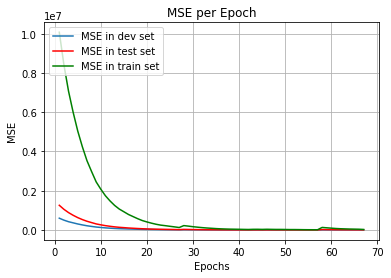


w: [-3.42642629 -8.32897124  7.49530076  8.32430811  6.59275152  4.81961635
 -5.83013374  2.74521939  6.82639578  7.10917538]
b: -3.194937982263362
MSE in test set: 1184.773830131023


In [8]:
from sklearn import datasets


def linear_regression(D, epochs=100, learning_rate=0.1, minibatch=10, history=False, patience=10):
    D_train = D['train']
    D_dev = D['dev']
    D_test = D['test']

    # initialize model parameters
    w = np.zeros(len(D_train[0][0]))
    b = 0

    x, y, y2, y3 = [], [], [], []
    linear_models = []

    # for early_stopping
    best_devmse = (0, float('inf'))
    patience_cnt = patience
    early_stopping = False

    for epoch in xrange(epochs):

        w, b = SGD(D_train, w, b, learning_rate, minibatch, history)

        devmse = sum((pval(D_dev[e_idx], w, b) - val(D_dev[e_idx]))**2 for e_idx in xrange(len(D_dev)))
        testmse = sum((pval(D_test[e_idx], w, b) - val(D_test[e_idx]))**2 for e_idx in xrange(len(D_test)))
        trainmse = sum((pval(D_train[e_idx], w, b) - val(D_train[e_idx]))**2 for e_idx in xrange(len(D_train)))

        print 'Epoch: %s' % (epoch+1)
        print 'MSE in dev set= %.4f' % devmse
        print 'MSE in test set= %.4f' % testmse

        x.append(epoch + 1)
        y.append(devmse)
        y2.append(testmse)
        y3.append(trainmse)

        # simple early stopping
        if best_devmse[1] > devmse:
            best_devmse = (epoch, devmse)
            patience_cnt = patience
        else:
            patience_cnt -= 1
            if not patience_cnt:
                early_stopping = True
                print 'Early stopping: Overfitting at %dth epoch' % (best_devmse[0]+1)
                break

        # Add available models
        linear_models.append((w, b, testmse))

    plt.title('MSE per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.plot(x, y, label='MSE in dev set')
    plt.plot(x, y2, 'r', label='MSE in test set')
    plt.plot(x, y3, 'g', label='MSE in train set')
    plt.legend(loc=2)
    plt.grid(True)
    plt.show()

    if early_stopping:
        return min(linear_models[:best_devmse[0]], key=lambda m: m[2])
    else:
        return min(linear_models, key=lambda m: m[2])


def SGD(train, w, b, learning_rate=0.1, minibatch=10, history=False):
    np.random.shuffle(train)
    trainsize = len(train)

    for i in xrange(0, trainsize, minibatch):
        if i + minibatch > trainsize:
            minibatch = trainsize - i

        X = np.column_stack([train[j][0] for j in xrange(i, i+minibatch)])
        y = np.array([train[j][1]-b for j in xrange(i, i+minibatch)])

        local_w = np.linalg.lstsq(np.dot(X, X.T), np.dot(X, y), rcond=None)[0]
        local_b = np.mean(y) + b - np.mean(np.dot(w, X))

        # ISGD update
        w -= (w - local_w) * learning_rate
        b -= (b - local_b) * learning_rate
        MSE = sum((pval(train[e_idx], w, b) - val(train[e_idx]))**2 for e_idx in xrange(i + minibatch))

        if history:
            print '-----------------------------'
            print 'Train progress: %.2f %%' % (((i+1.0)/trainsize)*100)
            print "w: %s" % w
            print "b: %s" % b
            print "MSE in train set: %s" % MSE

    return w, b


D = gen_dataset(1000, d=10)

# [0] weight vector [1] bias [2] test mse
model = linear_regression(D, learning_rate=0.001, history=False)

print '\nw: %s' % model[0]
print 'b: %s' % model[1]
print 'MSE in test set: %s' % model[2]
